
# Assignment 3

This is a template notebook for Assignment 3.


## Install dependencies and initialization

In [ ]:
# The next 8 lines added to be compatible with version changes (2022/10/13).
# change cuda to 11.1
import os
p = os.getenv('PATH')
ld = os.getenv('LD_LIBRARY_PATH')
os.environ['PATH'] = f"/usr/local/cuda-11.1/bin:{p}"
os.environ['LD_LIBRARY_PATH'] = f"/usr/local/cuda-11.1/lib64:{ld}"
# change pytorch to 1.9.0 compiled with cuda 11.1
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html


# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html

In [ ]:
!pwd # shows current directory
!ls  # shows all files in this directory
!nvidia-smi # shows the specs and the current status of the allocated GPU

In [ ]:
# import some common libraries
from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import datetime
import random
import json
import cv2
import csv
import os

# import some common pytorch utilities
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch

# import some common detectron2 utilities
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import build_detection_test_loader
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
setup_logger()

<Logger detectron2 (DEBUG)>

In [ ]:
# Make sure that GPU is available for your notebook. 
# Otherwise, you need to update the settungs in Runtime -> Change runtime type -> Hardware accelerator
torch.cuda.is_available()

True

In [ ]:
# You need to mount your google drive in order to load the data:
from google.colab import drive
drive.mount('/content/drive')
# Put all the corresponding data files in a data folder and put the data folder in a same directory with this notebook.
# Also create an output directory for your files such as the trained models and the output images.

Mounted at /content/drive


In [ ]:
# Define the location of current directory, which should contain data/train, data/test, and data/train.json.
# TODO: approx 1 line
# BASE_DIR = '/content/drive/My Drive/Colab Notebooks/03-cnn-detection-segmentation'
BASE_DIR = '/content/drive/My Drive/CMPT_CV_lab3'
OUTPUT_DIR = '{}/output'.format(BASE_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Part 1: Object Detection

### Data Loader

In [ ]:
'''
# This function should return a list of data samples in which each sample is a dictionary. 
# Make sure to select the correct bbox_mode for the data
# For the test data, you only have access to the images, therefore, the annotations should be empty.
# Other values could be obtained from the image files.
# TODO: approx 35 lines
'''
from glob import glob


def train(set_name): 
  data_dirs = f'{BASE_DIR}/data/train.json'
  with open(data_dirs) as j:
      imgs_anns = json.load(j)
  dataset_dicts={}
  # random.shuffle(imgs_anns)  # added
  for idx, v in enumerate(tqdm(imgs_anns)):
      filename = os.path.join(f'{BASE_DIR}/data/train', v["file_name"])
      annotations = v["segmentation"]
      px = [annotations[0][i] for i in range(0, len(annotations[0]), 2)]
      py = [annotations[0][i] for i in range(1, len(annotations[0]), 2)]
      poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
      poly = [p for x in poly for p in x]
      obj = {
          "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
          "bbox_mode": BoxMode.XYXY_ABS,
          "segmentation": [poly],
          "category_id": 0,
      }
      if not filename in dataset_dicts:
          dataset_dicts[filename] = {}
          dataset_dicts[filename]['annotations'] = []
          width, height = Image.open(filename).size
          dataset_dicts[filename]['file_name'] = filename
          dataset_dicts[filename]['image_id'] = idx
          dataset_dicts[filename]['height'] = int(height)
          dataset_dicts[filename]['width'] = int(width)
      dataset_dicts[filename]['annotations'].append(obj)
  dataset_dicts = np.array(list(dataset_dicts.values()))

  return dataset_dicts


### Get train_dataset, val_dataset fixed outside function, otherwise overlapping would happen!
dataset_dic = train('train.json') # all train folder data
dataset_dic = dataset_dic.tolist()
whole_size = len(dataset_dic)
split_ratio = 0.8
train_size = int(split_ratio * len(dataset_dic))
train_dataset = dataset_dic[:train_size]
val_dataset = dataset_dic[train_size:]


def get_detection_data(set_name):
  if set_name == 'validation.json':
    return val_dataset

  if set_name == 'test.json':
      dataset_dicts = []
      for f in tqdm(glob(f'{BASE_DIR}/data/test/*')):
          entry = {}
          width, height = Image.open(f).size
          entry['file_name'] = f
          entry['height'] = int(height)
          entry['width'] = int(width)
          entry['annotations'] = []
          dataset_dicts.append(entry)
      return dataset_dicts

  else:
    return train_dataset

  0%|          | 0/7980 [00:00<?, ?it/s]

In [ ]:
'''
# Remember to add your dataset to DatasetCatalog and MetadataCatalog
# Consdier "data_detection_train" and "data_detection_test" for registration
# You can also add an optional "data_detection_val" for your validation by spliting the training data
# TODO: approx 5 lines
'''

for d in ["train","test",'validation']:
    DatasetCatalog.register("data_detection_" + d, lambda d=d: get_detection_data(d+'.json'))
    MetadataCatalog.get("data_detection_" + d).set(thing_classes=["planes"])
    
plane_metadata = MetadataCatalog.get("data_detection_train")

In [ ]:
# !nvidia-smi
# !kill 460.32.03

# remove registered data
# DatasetCatalog.remove('data_detection_train')
# DatasetCatalog.remove('data_detection_test')
# DatasetCatalog.remove('data_detection_validation')

In [ ]:
# check registered datasets size
train_data_list = DatasetCatalog.get("data_detection_{}".format('train'))
print(len(train_data_list))
val_data_list = DatasetCatalog.get("data_detection_{}".format('validation'))
print(len(val_data_list))

158
40


In [ ]:
'''
# Visualize some samples using Visualizer to make sure that the function works correctly
# TODO: approx 5 lines
'''
dataset_dicts = get_detection_data("train.json")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=plane_metadata, scale=0.2)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

### Set Configs

In [ ]:
'''
# Set the configs for the detection part in here.
# TODO: approx 15 lines
'''

from detectron2.engine import DefaultTrainer

# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg = get_cfg()
cfg.OUTPUT_DIR = "{}/output/".format(BASE_DIR)
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("data_detection_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 4 #2
cfg.SOLVER.BASE_LR = 0.001 #0.00025 - good option  # pick a good LR
cfg.SOLVER.MAX_ITER = 900   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  
cfg.SOLVER.STEPS = [] 

### Training

In [ ]:
'''
# Create a DefaultTrainer using the above config and train the model
# TODO: approx 5 lines
'''

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
# tensorboard --logdir output  # need to specify path to make board active
%tensorboard --logdir drive/My\ Drive/CMPT_CV_lab3/output

### Evaluation and Visualization

In [ ]:
'''
# After training the model, you need to update cfg.MODEL.WEIGHTS
# Define a DefaultPredictor
'''
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
'''
# Visualize the output for 3 random test samples
# TODO: approx 10 lines
'''
dataset_dicts = get_detection_data("test.json")
# plane_val_metadata = MetadataCatalog.get("data_detection_val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=plane_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
'''
# Use COCOEvaluator and build_detection_train_loader
# You can save the output predictions using inference_on_dataset
# TODO: approx 5 lines
'''
evaluator = COCOEvaluator("data_detection_validation", output_dir=cfg.OUTPUT_DIR) #"./output")
val_loader = build_detection_test_loader(cfg, "data_detection_validation")
print(inference_on_dataset(predictor.model, val_loader, evaluator))


### Improvements

For this part, you can bring any improvement which you have by adding new input parameters to the previous functions or defining new functions and variables.

In [ ]:
'''
# Bring any changes and updates regarding the improvement in here
'''
## use the modified parameters in previous parts to run the cells
## therefore, not include details of cells here.
MAX_ITER = 900
BATCH_SIZE_PER_IMAGE = 512
IMS_PER_BATCH = 4 # 2
BASE_LR = 0.00025
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))


## Part 2: Semantic Segmentation

### Data Loader

In [ ]:
# speed increasing: load images to memory
# from glob import glob 

# data_dirs = '{}/data'.format(BASE_DIR)
# file_lst = glob(os.path.join(data_dirs, 'train', 'P*.png'))
# im_memory_imgs = {filename: cv2.imread(filename) for filename in tqdm(file_lst)}
# i = 0
# for filename in tqdm(file_lst):
#   i += 1
#   if i > 99:
#     break
#   else:
#     im_memory_imgs = {filename: cv2.imread(filename)}

In [ ]:
'''
# Write a function that returns the cropped image and corresponding mask regarding the target bounding box
# idx is the index of the target bbox in the data
# high-resolution image could be passed or could be load from data['file_name']
# You can use the mask attribute of detectron2.utils.visualizer.GenericMask 
#     to convert the segmentation annotations to binary masks
# TODO: approx 10 lines
'''

def get_instance_sample(data, img=None):

  filename = data['file_name']
  img = cv2.imread(filename)
  dic = {'img': [], 'mask':[]}

  for idx in range(len(data['annotations'])):
      annos = data['annotations'][idx]
      bbox = annos['bbox']
      x1, y1, x2, y2 = [int(i) for i in bbox]
      obj_img = img[y1:y2, x1:x2]
      segs = annos['segmentation'][0]
      obj_mask = detectron2.utils.visualizer.GenericMask(data["annotations"][idx]["segmentation"], data['height'], data['width']).mask
      obj_mask = obj_mask[y1:y2, x1:x2] * 255
      obj_img = cv2.resize(obj_img, (128, 128), interpolation = cv2.INTER_CUBIC) 
      obj_mask = cv2.resize(obj_mask, (128, 128), interpolation = cv2.INTER_CUBIC)
      dic['img'].append(obj_img)
      dic['mask'].append(obj_mask)
      
  return dic


In [ ]:
m = get_detection_data('train.json')
data = {'img':[], 'masks':[]} 

for i in tqdm(m):
    fname = i["file_name"].split('/')[-1].split('.')[0]
    dic = get_instance_sample(i)
    data['img'] += [dic['img']]
    data['masks'] += [dic['mask']]


  0%|          | 0/158 [00:00<?, ?it/s]

In [ ]:
## Check registered datasets size
train_data_list = DatasetCatalog.get("data_detection_{}".format('train'))
print(len(train_data_list))
val_data_list = DatasetCatalog.get("data_detection_{}".format('validation'))
print(len(val_data_list))

In [ ]:
'''
# We have provided a template data loader for your segmentation training
# You need to complete the __getitem__() function before running the code
# You may also need to add data augmentation or normalization in here
'''

class PlaneDataset(Dataset):  # input: data_detection_{train/...}
  def __init__(self, set_name, data_list):
      self.transforms = transforms.Compose([
          transforms.ToTensor(), # Converting the image to tensor and change the image format (Channels-Last => Channels-First)
      ])
      self.set_name = set_name
      self.data = data_list  # data_list: data_detection_... dataset registered
      self.instance_map = []
      for i, d in enumerate(self.data):
        for j in range(len(d['annotations'])):
          self.instance_map.append([i,j]) # instance_map: list([i,j]) - i: which input image, j: which bbox.


  '''
  # you can change the value of length to a small number like 10 for debugging of your training procedure and overfeating
  # make sure to use the correct length for the final training
  '''
  def __len__(self):
      return len(self.instance_map)

  def numpy_to_tensor(self, img, mask):
    if self.transforms is not None:
        img = self.transforms(img)
        mask = self.transforms(mask)
    img = torch.as_tensor(img, dtype=torch.float)
    mask = torch.as_tensor(mask, dtype=torch.float)
    return img, mask

  '''
  # Complete this part by using get_instance_sample function
  # make sure to resize the img and mask to a fixed size (for example 128*128)
  # you can use "interpolate" function of pytorch or "numpy.resize"
  # TODO: 5 lines
  '''
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()
    idx = self.instance_map[idx] # get [i,j]
    ## added
    which_data, which_box = idx[0], idx[1]
    obj_mask = data['masks'][which_data][which_box]
    obj_img = data['img'][which_data][which_box]
    img, mask = self.numpy_to_tensor(obj_img, obj_mask) 
    # print('#')
    # print(img.shape) # (128,128,3)
    # print(mask.shape) # (128,128,1)   
    return img, mask

def get_plane_dataset(set_name='train', batch_size=2):
    my_data_list = DatasetCatalog.get("data_detection_{}".format(set_name))
    dataset = PlaneDataset(set_name, my_data_list)
    loader = DataLoader(dataset, batch_size=batch_size, num_workers=4, pin_memory=False, shuffle=True)
    return loader, dataset

### Network

In [ ]:
'''
# convolution module as a template layer consists of conv2d layer, batch normalization, and relu activation
'''
class conv(nn.Module):
    def __init__(self, in_ch, out_ch, activation=True):
        super(conv, self).__init__()
        if(activation):
          self.layer = nn.Sequential(
             nn.Conv2d(in_ch, out_ch, 3, padding=1),
             nn.BatchNorm2d(out_ch),
             nn.ReLU(inplace=True)
          )
        else:
          self.layer = nn.Sequential(
             nn.Conv2d(in_ch, out_ch, 3, padding=1)  
             )

    def forward(self, x):
        x = self.layer(x)
        return x

'''
# downsampling module equal to a conv module followed by a max-pool layer
'''
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.layer = nn.Sequential(
            conv(in_ch, out_ch),
            nn.MaxPool2d(2)
            )

    def forward(self, x):
        x = self.layer(x)
        return x

'''
# upsampling module equal to a upsample function followed by a conv module
'''
class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch, 2, stride=2)

        self.conv = conv(in_ch, out_ch)

    def forward(self, x):
        y = self.up(x)
        y = self.conv(y)
        return y

'''
# the main model which you need to complete by using above modules.
# you can also modify the above modules in order to improve your results.
'''
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # Encoder
        
        # self.input_conv = conv(3, 4)
        # self.down = down(4, 8)
        ## added
        self.input_conv = conv(3, 8)
        self.down_1 = down(8, 16)
        self.down_2 = down(16, 32)
        # self.down_1 = down(8, 32)
        self.down_3 = down(32, 64)
        self.down_4 = down(64, 128)
        self.down_5 = down(128, 256)
        self.down_6 = down(256, 512)
        # self.input_conv = conv(3, 64)
        # self.down_1 = down(64, 64)
        # self.down_2 = down(64, 128)
        # # self.down_1 = down(8, 32)
        # self.down_3 = down(128, 256)
        # self.down_4 = down(256, 256)
        # self.down_5 = down(256, 512)
        # self.down_6 = down(512, 1024)
        

        # Decoder
        
        # self.up = up(8, 4)
        # self.output_conv = conv(4, 1, False) # ReLu activation is removed to keep the logits for the loss function
        ## added
        self.up_1 = up(512, 256)
        self.up_2 = up(256, 128)
        self.up_3 = up(128, 64)
        self.up_4 = up(64, 32)
        # self.up_5 = up(32, 8)
        self.up_5 = up(32, 16)
        self.up_6 = up(16, 8)
        self.up_7 = conv(8, 3)
        self.output_conv = conv(3, 1, False) # ReLu activation is removed to keep the logits for the loss function
        # self.up_1 = up(1024, 512)
        # self.up_2 = up(512, 256)
        # self.up_3 = up(256, 128)
        # self.up_4 = up(128, 64)
        # # self.up_5 = up(32, 8)
        # self.up_5 = up(64, 32)
        # self.up_6 = up(32, 16)
        # self.up_7 = conv(16, 3)
        # self.output_conv = conv(3, 1, False)

        self.normal_1 = nn.BatchNorm2d(8)
        self.normal_2 = nn.BatchNorm2d(16)
        self.normal_3 = nn.BatchNorm2d(32)
        self.normal_4 = nn.BatchNorm2d(64)
        self.normal_5 = nn.BatchNorm2d(128)
        self.normal_6 = nn.BatchNorm2d(256)

        # self.normal_1 = nn.BatchNorm2d(16)
        # self.normal_2 = nn.BatchNorm2d(32)
        # self.normal_3 = nn.BatchNorm2d(128)
        # self.normal_4 = nn.BatchNorm2d(128)
        # self.normal_5 = nn.BatchNorm2d(256)
        # self.normal_6 = nn.BatchNorm2d(512)

    def forward(self, input):
      # y = self.input_conv(input)
      # y = self.down(y)
      # y = self.up(y)
      # output = self.output_conv(y)
      ## added
      y_1 = self.input_conv(input)
      y_2 = self.down_1(y_1)
      y_3 = self.down_2(y_2)
      # y_3 = self.down_1(y_1) # (8,32)
      y_4 = self.down_3(y_3)
      y_5 = self.down_4(y_4)
      y_6 = self.down_5(y_5)
      y_7 = self.down_6(y_6)
      y_7 = self.normal_6(F.relu(self.up_1(y_7) + y_6))
      y_6 = self.normal_5(F.relu(self.up_2(y_7) + y_5))
      y_5 = self.normal_4(F.relu(self.up_3(y_6) + y_4))
      y_4 = self.normal_3(F.relu(self.up_4(y_5) + y_3))
      y_3 = self.normal_2(F.relu(self.up_5(y_4) + y_2))
      y_2 = self.normal_1(F.relu(self.up_6(y_3) + y_1))
      y = self.up_7(y_2)
      output = self.output_conv(y)

      # y_1 = self.input_conv(input)
      # y_2 = self.down_1(y_1)
      # y_3 = self.down_2(y_2)
      # # y_3 = self.down_1(y_1) # (8,32)
      # y_4 = self.down_3(y_3)
      # y_5 = self.down_4(y_4)
      # y_6 = self.down_5(y_5)
      # y_7 = self.down_6(y_6)
      # y_7 = self.normal_6(F.relu(self.up_1(y_7) + y_6))
      # y_6 = self.normal_5(F.relu(self.up_2(y_7) + y_5))
      # y_5 = self.normal_4(F.relu(self.up_3(y_6) + y_4))
      # y_4 = self.normal_3(F.relu(self.up_4(y_5) + y_3))
      # y_3 = self.normal_2(F.relu(self.up_5(y_4) + y_2))
      # y_2 = self.normal_1(F.relu(self.up_6(y_3) + y_1))
      # y = self.up_7(y_2)
      # output = self.output_conv(y)

      return output

### Training

In [ ]:
import gc

# model.cpu()
# del model, checkpoint
# gc.collect()
torch.cuda.empty_cache
# torch.cuda.clear_cache

<function torch.cuda.memory.empty_cache() -> None>

In [ ]:
'''
# The following is a basic training procedure to train the network
# You need to update the code to get the best performance
# TODO: approx ? lines
'''

# Set the hyperparameters
num_epochs = 10 #5
batch_size = 4 #4
learning_rate = 0.01 # 0.1
weight_decay = 1e-5

model = MyModel() # initialize the model
model = model.cuda() # move the model to GPU
loader, _ = get_plane_dataset('train', batch_size) # initialize data_loader
crit = nn.BCEWithLogitsLoss() # Define the loss function
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # Initialize the optimizer as SGD
# lr_i = 1
loss_lst = []

# start the training procedure
for epoch in range(num_epochs):
  total_loss = 0
  # lr scheduler
  # if lr_i % 15 == 0 and lr_i > 16:
  #   for param_group in optim.param_groups:
  #     param_group['lr'] /=10
  loss_cnt = 0
  loss_epoch = 0
  for (img, mask) in tqdm(loader):
    img = torch.tensor(img.float(), device=torch.device('cuda'), requires_grad = True)
    mask = torch.tensor(mask.float(), device=torch.device('cuda'), requires_grad = True)
    pred = model(img)
    loss = crit(pred, mask)
    optim.zero_grad()
    loss.backward()
    optim.step()
    total_loss += loss.cpu().data
    ## added
    # i += 1
    # if i == 300:
    #   break
    loss_epoch += loss.cpu().data
    loss_cnt += 1

  avg_loss_epoch = loss_epoch / loss_cnt
  loss_lst.append(avg_loss_epoch)

  print("Epoch: {}, Loss: {}".format(epoch, total_loss/len(loader)))
  torch.save(model.state_dict(), '{}/output/{}_segmentation_model.pth'.format(BASE_DIR, epoch))

'''
# Saving the final model
'''
torch.save(model.state_dict(), '{}/output/final_segmentation_model.pth'.format(BASE_DIR))


  0%|          | 0/1596 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0, Loss: 0.30872631072998047


  0%|          | 0/1596 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.22202008962631226


  0%|          | 0/1596 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.20362676680088043


  0%|          | 0/1596 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.19309861958026886


  0%|          | 0/1596 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.1840268075466156


  0%|          | 0/1596 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.17803716659545898


  0%|          | 0/1596 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.17253920435905457


  0%|          | 0/1596 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.16745488345623016


  0%|          | 0/1596 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.16283674538135529


  0%|          | 0/1596 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.1581665724515915


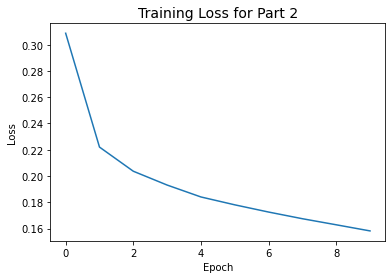

In [ ]:
### plot training loss over epoches
import matplotlib.pyplot as plt

loss_vals = np.asarray(torch.tensor(loss_lst).cpu())
plt.title('Training Loss for Part 2', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss_vals)
# loss_vals = [0.30872631072998047, 0.22202008962631226, 0.20362676680088043, 0.19309861958026886, 0.1840268075466156, 0.17803716659545898, 0.17253920435905457, 0.16745488345623016, 0.16283674538135529, 0.1581665724515915]


In [ ]:
### plot training loss over all iterations
# plt.figure(1, figsize=(100,80))
# x_val = np.arange(loss_cnt)
# loss_val = torch.tensor(loss_lst).cpu()
# loss_val = np.asarray(loss_val)
# print(type(x_val)) # nd array

# plt.title('Training Loss for Part 2', fontsize=12)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.plot(loss_val)

In [ ]:
## model structure summary
from torchvision import models
from torchsummary import summary

model = MyModel().cuda()
summary(model, (3,128, 128))

### Evaluation and Visualization

In [ ]:
'''
# Before starting the evaluation, you need to set the model mode to eval
# You may load the trained model again, in case if you want to continue your code later
# TODO: approx 15 lines
'''
batch_size = 1
model = MyModel().cuda()
model.load_state_dict(torch.load('{}/output/final_segmentation_model.pth'.format(BASE_DIR)))
model = model.eval() 
loader, dataset = get_plane_dataset('train', batch_size)


'''
## Complete the code by obtaining the IoU for each img and print the final Mean IoU
'''

def sigmoid(x):
  return 1/(1 + np.exp(-x))


def iou(y_true, y_pred):
  
  ## convert-to-mask: normalization method
  ## need to have different numbers rather than all 1
  # m, std = torch.mean(preds[i]),torch.std(preds[i])
  # threshold = (preds[i] - m) / std
  # p_img = (threshold > 0).int()
  # p_mask = masks[i].reshape(128,128)
  # p_mask = np.asarray(p_mask.cpu())

  # p_img = np.asarray(p_img.cpu()) # (16384)
  # p_img = np.reshape(p_img, (128,128))
  # pred_area = np.count_nonzero(p_img == 1)      
  # mask_area = np.count_nonzero(p_mask == 1)
  # intersection = np.count_nonzero( np.logical_and(p_img, p_mask) )

  # inputs are arrays
  y_true = np.rint(sigmoid(y_true))
  y_pred = np.rint(sigmoid(y_pred))
  intersection = np.count_nonzero(np.multiply(y_true, y_pred))
  union = np.count_nonzero(y_true + y_pred)
  if union == 0:
    return 0
  else:
    iou_val = intersection/union
    return iou_val


total_iou = 0
cnt = 0

for (img, mask) in tqdm(loader):
  with torch.no_grad():
    img = img.cuda()
    mask = mask.cpu().detach()
    pred = model(img).cpu().detach()

    for i in range(img.shape[0]):
        t_mask = np.array(mask[i])[0] # np array
        p_mask = np.array(pred[i])[0]
        # print(type(t_mask))
        total_iou += iou(t_mask, p_mask)
        cnt += 1
    

print("\n #images: {}, Mean IoU: {}".format(cnt, total_iou/cnt))


  0%|          | 0/6382 [00:00<?, ?it/s]


 #images: 6382, Mean IoU: 0.7761640252911344


In [ ]:
''' view one train sample '''

# import matplotlib.pyplot as plt

# dataset_dicts = get_detection_data("train")
# sample_imgs = random.sample(dataset_dicts, 1)[0]
# idx = random.randint(0, len(sample_imgs['annotations'])-1)
# obj_img, obj_mask = get_instance_sample(sample_imgs, idx) 

# plt.imshow(obj_img)
# plt.show()
# plt.imshow(obj_mask)
# plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

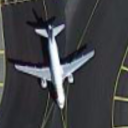

(128, 128, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


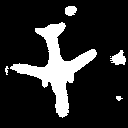

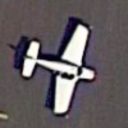

(128, 128, 1)


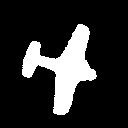

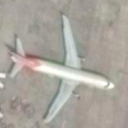

(128, 128, 1)


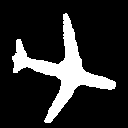

In [ ]:
'''
# Visualize 3 sample outputs
# TODO: approx 5 lines
'''
from glob import glob
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

batch_size = 4
size_after = 128
model = MyModel().cuda()
model.load_state_dict(torch.load('{}/output/final_segmentation_model.pth'.format(BASE_DIR)))
model = model.eval()

data_dirs = '{}/data'.format(BASE_DIR)
file_lst = glob(os.path.join(data_dirs, 'part2-visualization', 'test*.png'))

for filename in tqdm(file_lst):
  img = cv2.imread(filename)
  img_resized = cv2.resize(img, (size_after, size_after), interpolation=cv2.INTER_AREA) # shape: (128,128,3) to display
  cv2_imshow(img_resized)

  trans = transforms.ToTensor()
  img_tensor1 = trans(img_resized) # (3,128,128)
  img_tensor = torch.tensor(img_tensor1, dtype=torch.float)
  img_tensor = img_tensor.unsqueeze(0).cuda()
  # img_tensor = trans(img)
  # print(img_tensor.shape) # (1,3,128,128)
  # img_tensor = img_tensor.unsqueeze(0).cuda()
  pred = model(img_tensor) # output (1,1,128,128)

  ## convert-to-mask trial: standardization method
  # threshold = (torch.max(pred[0]) + torch.min(pred[0])) / 2
  # p_mask = (pred > threshold).int() # shape: (1,1,128,128)
  # p_mask = p_mask.squeeze(0) # shape: (1,128,128)
  # print(p_mask.shape)
  # cv2_imshow((p_mask[0].permute(1, 2, 0).cpu()).numpy() * 255)

  ## convert-to-mask trial: normalization method
  # m, std = torch.mean(pred[0]), torch.std(pred[0])
  # p_mask = (((pred[0] - m) / std) > 0).int()
  # # print(p_mask)
  # cv2_imshow(p_mask.permute(1, 2, 0).cpu().numpy()*255)
  
  ## convert-to-mask trial: sigmoid method
  p_mask = torch.squeeze(pred, 0)
  p_mask = np.rint(torch.sigmoid(p_mask).permute(1, 2, 0).cpu().detach().numpy())
  print(p_mask.shape)
  cv2_imshow(p_mask*255)

## Part 3: Instance Segmentation

In this part, you need to obtain the instance segmentation results for the test data by using the trained segmentation model in the previous part and the detection model in Part 1.

### Get Prediction

In [ ]:
## separate for running
model = MyModel()
model = model.cuda()
model.load_state_dict(torch.load('{}/output/final_segmentation_model.pth'.format(BASE_DIR)))

<All keys matched successfully>

In [ ]:
'''
# Define a new function to obtain the prediction mask by passing a sample data
# For this part, you need to use all the previous parts (predictor, get_instance_sample, data preprocessings, etc)
# TODO: approx 35 lines
'''

def sigmoid(x):
  return 1/(1 + np.exp(-x))


def get_prediction_mask(my_data, train=False):
  # input data: each image info
  img = cv2.imread(my_data['file_name'])

  if train:

      pred_mask = np.zeros([my_data['height'], my_data['width']])
      imgs = []

      for i,j in enumerate(my_data['annotations']):
          bbox = j['bbox']
          y1, x1, y2, x2 = bbox
          img_bbox_size = img[x1:x2, y1:y2]
          img_bbox_size = cv2.resize(img_bbox_size, (128, 128), interpolation = cv2.INTER_CUBIC) 
          prediction_from_mask = model(torch.unsqueeze(torch.tensor(transforms.ToTensor()(img_bbox_size), device=torch.device('cuda')),0)).cpu().detach().numpy()[0] 
          prediction_from_mask = cv2.resize(prediction_from_mask[0], (y2-y1, x2-x1), interpolation = cv2.INTER_CUBIC) 
          prediction_from_mask = np.rint(sigmoid(prediction_from_mask)) * (i+1)
          predicted_mask = pred_mask[x1:x2, y1:y2]
          predicted_mask[predicted_mask==0] = 10000
          overlapping = np.minimum(predicted_mask,prediction_from_mask)
          overlapping[overlapping == 1000] = 0
          pred_mask[x1:x2, y1:y2] = overlapping 

  else:

      prediction_for_img = predictor(img)['instances'] 
      pred_mask = np.zeros([my_data['height'], my_data['width']])
      imgs = []
      for i in range(len(prediction_for_img)):
          bbox = np.array(np.floor(list(prediction_for_img[i]._fields['pred_boxes'])[0].cpu().numpy()), dtype=np.uint32)
          y1, x1, y2, x2 = bbox
          to_be_masked = img[x1:x2, y1:y2]
          to_be_masked = cv2.resize(to_be_masked, (128, 128), interpolation = cv2.INTER_CUBIC) 
          prediction_from_mask = model(torch.unsqueeze(torch.tensor(transforms.ToTensor()(to_be_masked), device=torch.device('cuda')),0)).cpu().detach().numpy()[0]
          prediction_from_mask = cv2.resize(prediction_from_mask[0], (y2-y1, x2-x1), interpolation = cv2.INTER_CUBIC)
          prediction_from_mask = np.rint(sigmoid(prediction_from_mask))*(i+1)
          predicted_mask = pred_mask[x1:x2, y1:y2]
          predicted_mask[predicted_mask==0] = 10000
          overlapping = np.minimum(predicted_mask,prediction_from_mask)
          overlapping[overlapping == 1000] = 0
          pred_mask[x1:x2, y1:y2] = overlapping 

  true_mask = np.zeros([my_data['height'], my_data['width']])
  for j,i in enumerate(my_data['annotations']):
      bbox = i['bbox']
      y1, x1, y2, x2 = [int(i) for i in bbox]
      x2 += x1
      y2 += y1
      local_true_mask = detectron2.utils.visualizer.GenericMask(i['segmentation'], my_data['height'], my_data['width']).mask
      overlapping = np.maximum(true_mask[x1:x2, y1:y2], local_true_mask[x1:x2, y1:y2]*(j+1))
      true_mask[x1:x2, y1:y2] = overlapping
  gt_mask = torch.tensor(true_mask, device=torch.device('cuda'))
  p_mask = torch.tensor(pred_mask, device=torch.device('cuda'))

  return img, gt_mask, p_mask  # gt_mask could be all zero when the ground truth is not given.

### Visualization and Submission

In [ ]:
# cfg = get_cfg()
# cfg.OUTPUT_DIR = "{}/output/".format(BASE_DIR)

# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
# cfg.DATASETS.TRAIN = ("data_detection_train",)
# cfg.DATASETS.TEST = ("data_detection_val",)
# cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
# cfg.SOLVER.MAX_ITER = 500
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.00025
# cfg.SOLVER.STEPS = [] 
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

In [ ]:
## don't run if uncomment same lines in following cell
model = MyModel().cuda()
model.load_state_dict(torch.load('{}/output/final_segmentation_model.pth'.format(BASE_DIR)))

dataset = get_detection_data('test.json')

  0%|          | 0/72 [00:00<?, ?it/s]

In [ ]:
'''
# Visualise the output prediction as well as the GT Mask and Input image for a sample input
# TODO: approx 10 lines
'''
# dataset = get_detection_data('test.json')

for i in np.random.randint(0,50,3):

  img, gt_mask, p_mask = get_prediction_mask(dataset[i])
  p_mask = p_mask.cpu().numpy()
  gt_mask = gt_mask.cpu().numpy()
  max_val = p_mask.max()
  fact = 255./max_val
  p_mask*= fact
  max_val = gt_mask.max()
  fact = 255./max_val
  gt_mask *= fact
  cv2_imshow(cv2.resize(img, (img.shape[1]//3, img.shape[0]//3), interpolation = cv2.INTER_CUBIC))
  # cv2_imshow(cv2.resize(true_mask, (true_mask.shape[1]//3, true_mask.shape[0]//3), interpolation = cv2.INTER_CUBIC))
  cv2_imshow(cv2.resize(p_mask, (p_mask.shape[1]//3, p_mask.shape[0]//3), interpolation = cv2.INTER_CUBIC))


In [ ]:
'''
# ref: https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
# https://www.kaggle.com/c/airbus-ship-detection/overview/evaluation
'''
def rle_encoding(x):
    '''
    x: pytorch tensor on gpu, 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = torch.where(torch.flatten(x.long())==1)[0]
    if(len(dots)==0):
      return []
    inds = torch.where(dots[1:]!=dots[:-1]+1)[0]+1
    inds = torch.cat((torch.tensor([0], device=torch.device('cuda'), dtype=torch.long), inds))
    tmpdots = dots[inds]
    inds = torch.cat((inds, torch.tensor([len(dots)], device=torch.device('cuda'))))
    inds = inds[1:] - inds[:-1]
    runs = torch.cat((tmpdots, inds)).reshape((2,-1))
    runs = torch.flatten(torch.transpose(runs, 0, 1)).cpu().data.numpy()
    return ' '.join([str(i) for i in runs])

In [ ]:
## don't run if uncomment same lines in following cell
train_data_list = DatasetCatalog.get("data_detection_{}".format('train'))
print(len(train_data_list))
val_data_list = DatasetCatalog.get("data_detection_{}".format('validation'))
print(len(val_data_list))
test_data_list = DatasetCatalog.get("data_detection_{}".format('test'))
print(len(test_data_list))

158
40


  0%|          | 0/72 [00:00<?, ?it/s]

72


In [ ]:
'''
# You need to upload the csv file on kaggle
# The speed of your code in the previous parts highly affects the running time of this part
'''

preddic = {"ImageId": [], "EncodedPixels": []}

'''
# Writing the predictions of the training set
'''
# train_data_list = DatasetCatalog.get("data_detection_{}".format('train'))
for i in tqdm(range(len(train_data_list)), position=0, leave=True):
  sample = train_data_list[i]
  sample['image_id'] = sample['file_name'].split("/")[-1][:-4]
  img, _, pred_mask = get_prediction_mask(sample, True)
  inds = torch.unique(pred_mask)
  if(len(inds)==1):
    preddic['ImageId'].append(sample['image_id'])
    preddic['EncodedPixels'].append([])
  else:
    for index in inds:
      if(index == 0):
        continue
      tmp_mask = (pred_mask==index)
      encPix = rle_encoding(tmp_mask)
      preddic['ImageId'].append(sample['image_id'])
      preddic['EncodedPixels'].append(encPix)


'''
# Writing the predictions of the validation set
'''
# val_data_list = DatasetCatalog.get("data_detection_{}".format('validation'))
for i in tqdm(range(len(val_data_list)), position=0, leave=True):
  sample = val_data_list[i]
  sample['image_id'] = sample['file_name'].split("/")[-1][:-4]
  img, _, pred_mask = get_prediction_mask(sample, True)
  inds = torch.unique(pred_mask)
  if(len(inds)==1):
    preddic['ImageId'].append(sample['image_id'])
    preddic['EncodedPixels'].append([])
  else:
    for index in inds:
      if(index == 0):
        continue
      tmp_mask = (pred_mask==index)
      encPix = rle_encoding(tmp_mask)
      preddic['ImageId'].append(sample['image_id'])
      preddic['EncodedPixels'].append(encPix)


'''
# Writing the predictions of the test set
'''

# test_data_list = DatasetCatalog.get("data_detection_{}".format('test'))
for i in tqdm(range(len(test_data_list)), position=0, leave=True):
  sample = test_data_list[i]
  sample['image_id'] = sample['file_name'].split("/")[-1][:-4]
  img, true_mask, pred_mask = get_prediction_mask(sample)
  inds = torch.unique(pred_mask)
  if(len(inds)==1):
    preddic['ImageId'].append(sample['image_id'])
    preddic['EncodedPixels'].append([])
  else:
    for j, index in enumerate(inds):
      if(index == 0):
        continue
      tmp_mask = (pred_mask==index).double()
      encPix = rle_encoding(tmp_mask)
      preddic['ImageId'].append(sample['image_id'])
      preddic['EncodedPixels'].append(encPix)

pred_file = open("{}/pred.csv".format(BASE_DIR), 'w')
pd.DataFrame(preddic).to_csv(pred_file, index=False)
pred_file.close()


  0%|          | 0/158 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

## Part 4: Mask R-CNN

For this part you need to follow a same procedure to part 2 with the configs of Mask R-CNN, other parts are generally the same as part 2.

### Data Loader

In [ ]:
dataset_dic = get_detection_data('validation')

for d in ["train","test",'validation']:
    DatasetCatalog.register("data_detection_" + d, lambda d=d: get_detection_data(d+'.json'))
    MetadataCatalog.get("data_detection_" + d).set(thing_classes=["planes"])
planes_metadata = MetadataCatalog.get("data_detection_train")

### Network

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("data_detection_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025 #0.002  # pick a good LR
cfg.SOLVER.MAX_ITER = 500    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
cfg.OUTPUT_DIR = f"{BASE_DIR}/output/"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


### Training

In [ ]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
predictor = DefaultPredictor(cfg)

### Evaluation and Visualization

In [ ]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = get_detection_data("validation.json")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=plane_metadata, 
                   scale=0.2, 
                   instance_mode=ColorMode.IMAGE_BW   
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("data_detection_validation", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "data_detection_validation")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
